## 币安期货多币种对冲策略研究

币安期货最近发起了“千团大战”活动（活动地址：https://www.binance-cn.com/cn/futures/activity/tournament ）。FMZ量化平台官方也组织了团队，直接搜索“FMZ”就可以找到，目前已经有200多人，欢迎参与，参加后可加下方微信，回复“币安”拉微信群。

<img src="https://www.fmz.com/upload/asset/1fbed0c3795dbecac04.jpg" />

参与活动的用户均可获取此币安期货策略（策略源码将在活动前放出，也可以直接根据此报告自己的代码）。本篇即为此策略的研究报告。**注意策略只供参考，可以在此基础上提出自己的思路进行优化，也欢迎分享。**报告可直接在FMZ网站的研究环境直接使用（点击右上角下载，在研究环境中上传）。

研究环境点击控制中心，再点击箭头位置即可进入，打开上传的.pynb后缀的文件，按shift+enter逐行运行即可。研究环境的使用帮助里有基础的使用教程。
<img src="https://www.fmz.com/upload/asset/1b39347a88aa4cff916.jpg" />

### 1.策略缘由

币安现货上架了许多山寨币，虽然短期涨跌不定，如果用日线观察久一些，就会发现基本都跌了90%以上，有的甚至只有最高价零头的零头。可是现货并没有普遍的做空手段，除了不碰山寨币，没有特别的建议。最近两月币安期货上线了二十多个永续合约，其中大多数时主流币种，也有一些默默无闻。这给了我们做空这些山寨币组合的手段。利用山寨币对于BTC往往下跌以及山寨币的走势相关系数很高，可以设计出两种策略。

### 2.策略原理

第一个策略：策略将分散等值做空选定的一篮子山寨币，同时等仓位做多比特币对冲，降低风险和波动率。随着价格的波动，不断调整仓位保持空头价值恒定和多头仓位对等。本质上时做空山寨币-比特币价格指数。

第二个策略：将做空价格高于山寨币-比特币价格指数的币种，做多低于指数的币种，偏离越大，仓位越大。同时将未对冲的头寸用BTC对冲（也可不对冲）。

In [1]:
# 需要导入的库
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

### 3.筛选需要的币种

币安永续合约当前上架币种，用API获取，不包含BTC共23个。但研究环境不能访问外网，这里直接给出列表。

In [2]:
#Info = requests.get('https://fapi.binance.com/fapi/v1/exchangeInfo')
#symbols = [symbol_info['baseAsset'] for symbol_info in Info.json()['symbols']]
symbols = ['ETH', 'BCH', 'XRP', 'EOS', 'LTC', 'TRX', 'ETC', 'LINK', 'XLM', 'ADA', 'XMR', 'DASH', 'ZEC', 'XTZ', 'BNB', 'ATOM', 'ONT', 'IOTA', 'BAT', 'VET', 'NEO', 'QTUM', 'IOST']

首先我们研究一下过去一年山寨币对比特币的价格走势，数据我已经提前下载好，并传到了论坛上，可以在研究环境中直接引用

In [3]:
price_btc = pd.read_csv('https://www.fmz.com/upload/asset/1ef1af8ec28a75a2dcb.csv', index_col = 0)
price_btc.index = pd.to_datetime(price_btc.index,unit='ms') #索引位日期

In [4]:
price_btc.tail()

,ETH,BCH,XRP,EOS,LTC,TRX,ETC,LINK,XLM,ADA,...,XTZ,BNB,ATOM,ONT,IOTA,BAT,VET,NEO,QTUM,IOST
0,,,,,,,,,,,,,,,,,,,,,
2020-03-21,0.021434,0.035580,0.000026,0.000368,0.006196,0.000002,0.000810,0.000367,0.000006,0.000005,...,0.000268,0.001956,0.000351,0.000060,0.000022,0.000022,4.700000e-07,0.001007,0.000199,5.600000e-07
2020-03-22,0.021026,0.034852,0.000025,0.000367,0.006086,0.000002,0.000789,0.000341,0.000006,0.000005,...,0.000253,0.001918,0.000330,0.000059,0.000022,0.000021,4.400000e-07,0.001022,0.000197,5.000000e-07
2020-03-23,0.021010,0.034186,0.000024,0.000353,0.006021,0.000002,0.000768,0.000348,0.000006,0.000005,...,0.000259,0.001883,0.000326,0.000058,0.000022,0.000021,4.400000e-07,0.001032,0.000191,5.100000e-07
2020-03-24,0.020529,0.033712,0.000024,0.000347,0.006012,0.000002,0.000751,0.000343,0.000006,0.000004,...,0.000261,0.001842,0.000318,0.000057,0.000021,0.000023,4.500000e-07,0.001022,0.000189,4.900000e-07
2020-03-25,0.020727,0.033480,0.000024,0.000348,0.005996,0.000002,0.000786,0.000339,0.000006,0.000004,...,0.000258,0.001857,0.000321,0.000056,0.000021,0.000023,4.600000e-07,0.001020,0.000187,4.900000e-07


先把这些币种价格画出来看看趋势，数据要归一化。可以看到除了四个币种外，其余币种的价格走势基本一致，呈现出下降趋势。

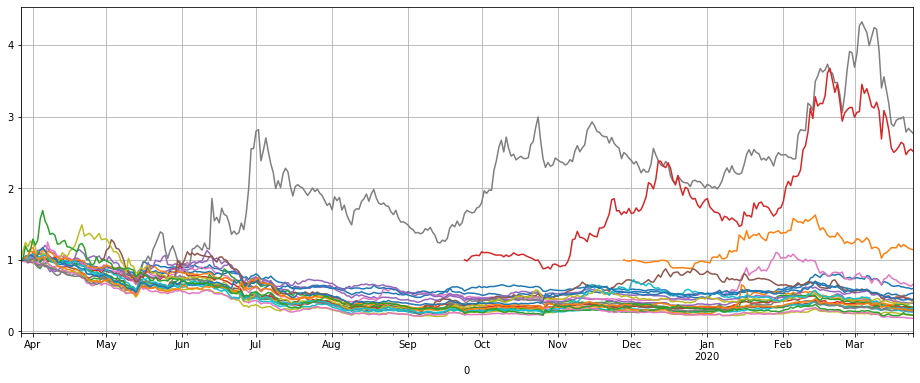

In [5]:
price_btc_norm = price_btc/price_btc.fillna(method='bfill').iloc[0,]
price_btc_norm.plot(figsize=(16,6),grid = True,legend=False);

将最后价格变化排一下序，就可以找到明显不同的几个币，分别是LINK，XTZ，BCH, ETH。说明它们往往能走出独立行情，做空它们风险较高，需要排除策略之外。
将剩余的币种再画一个相关系数的热力图，发现ETC，ATOM的走势也相对特殊，可以排除。

In [6]:
price_btc_norm.iloc[-1,].sort_values()[-5:]

ETH     0.600417
ETC     0.661616
BCH     1.141961
XTZ     2.512195
LINK    2.764495
Name: 2020-03-25 00:00:00, dtype: float64

In [7]:
trade_symbols = list(set(symbols)-set(['LINK','XTZ','BCH', 'ETH'])) #剩余的币种

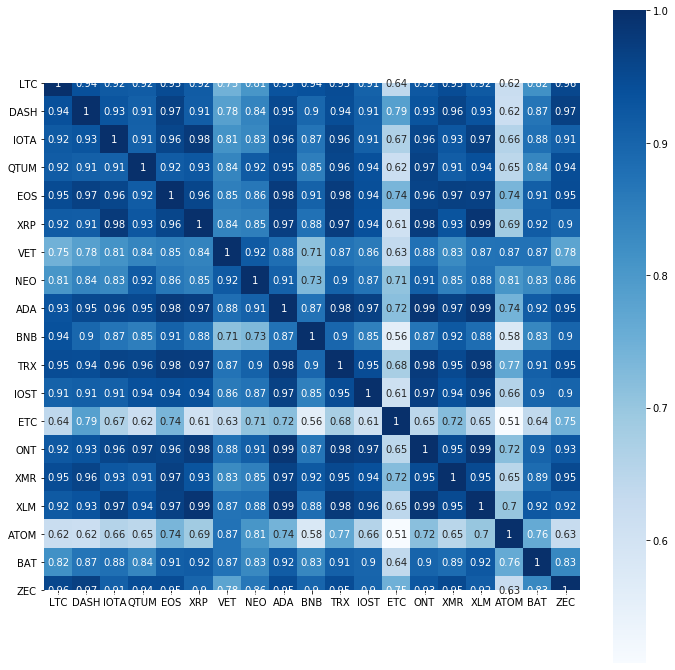

In [8]:
plt.subplots(figsize=(12, 12)) # 设置画面大小
sns.heatmap(price_btc[trade_symbols].corr(), annot=True, vmax=1, square=True, cmap="Blues");

最后剩余的币种一年平均下跌66%，显然有充足的做空空间。把这些币的趋势合成出山寨币价格指数，发现基本一路下跌，去年下半年较稳定，今年又开始一路下跌。本此研究筛选出'LINK','XTZ','BCH', 'ETH', 'ETC','ATOM','BNB','EOS','LTC'不参与第一个策略的做空，具体的币种可以自己回测。

**需要注意的是，现在的山寨币指数处于过去一年中低点，也许不是做空良机，反而可以做多，需要根据个人选择。**


In [9]:
trade_symbols = list(set(symbols)-set(['LINK','XTZ','BCH', 'ETH', 'ETC','ATOM','BNB','EOS','LTC'])) #剩余的币种，具体减去哪些，可自己设定。
1-price_btc_norm[trade_symbols].iloc[-1,].mean()

0.6714306758250285

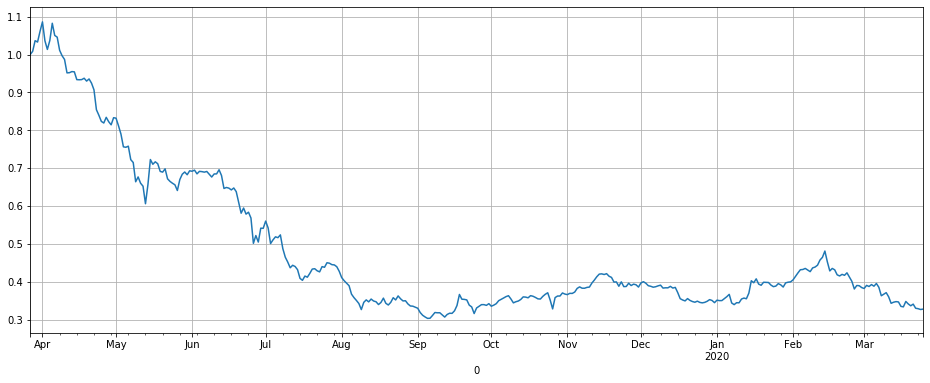

In [12]:
price_btc_norm[trade_symbols].mean(axis=1).plot(figsize=(16,6),grid = True,legend=False);

### 4.币安永续数据

同样的，币安永续的数据已经整理好了，你也可以在自己的notebook中直接引用，数据是2020年1月28到3月31日的1h行情K线，因为币安上线大部分永续合约的时间就这两个月，所以数据用于回测是够了。

In [14]:
price_usdt = pd.read_csv('https://www.fmz.com/upload/asset/20227de6c1d10cb9dd1.csv ', index_col = 0)
price_usdt.index = pd.to_datetime(price_usdt.index)

In [15]:
price_usdt.tail()

,BTC,ETH,BCH,XRP,EOS,LTC,TRX,ETC,LINK,XLM,...,XTZ,BNB,ATOM,ONT,IOTA,BAT,VET,NEO,QTUM,IOST
0,,,,,,,,,,,,,,,,,,,,,
2020-04-07 23:00:00,7192.90,164.55,252.51,0.1925,2.632,44.83,0.01329,5.475,2.729,0.04843,...,1.960,14.725,2.346,0.4219,0.1632,0.1611,0.003873,7.719,1.373,0.003394
2020-04-08 00:00:00,7153.32,164.42,251.62,0.1914,2.591,44.41,0.01321,5.415,2.719,0.04816,...,1.928,14.588,2.321,0.4167,0.1628,0.1600,0.003822,7.658,1.366,0.003368
2020-04-08 01:00:00,7160.02,163.83,250.55,0.1924,2.601,44.53,0.01321,5.428,2.758,0.04818,...,1.943,14.592,2.320,0.4152,0.1628,0.1633,0.003815,7.657,1.369,0.003373
2020-04-08 02:00:00,7262.37,168.74,264.67,0.1972,2.684,45.94,0.01352,5.586,2.808,0.04947,...,1.995,14.902,2.378,0.4244,0.1662,0.1674,0.003873,7.800,1.400,0.003442
2020-04-08 03:00:00,7378.88,172.81,275.81,0.2003,2.741,46.68,0.01371,5.720,2.838,0.05033,...,2.052,15.339,2.419,0.4355,0.1700,0.1702,0.003930,7.965,1.420,0.003484


先归一化数据看一下整体走势，在3月份的大跌中，相对于2月初的价格，普遍腰斩，可见永续的风险也很高，这波大跌也是对策略的考验。

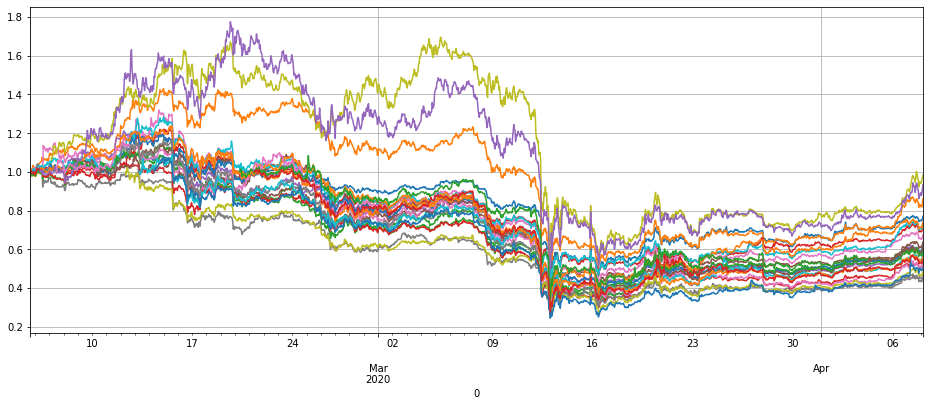

In [16]:
price_usdt_norm = price_usdt/price_usdt.fillna(method='bfill').iloc[0,]
price_usdt_norm.plot(figsize=(16,6),grid = True,legend=False);

将我们要做空的币相对于比特币的指数价格画出来，策略原理就是做空这条曲线，收益也基本上是这条曲线反过来。

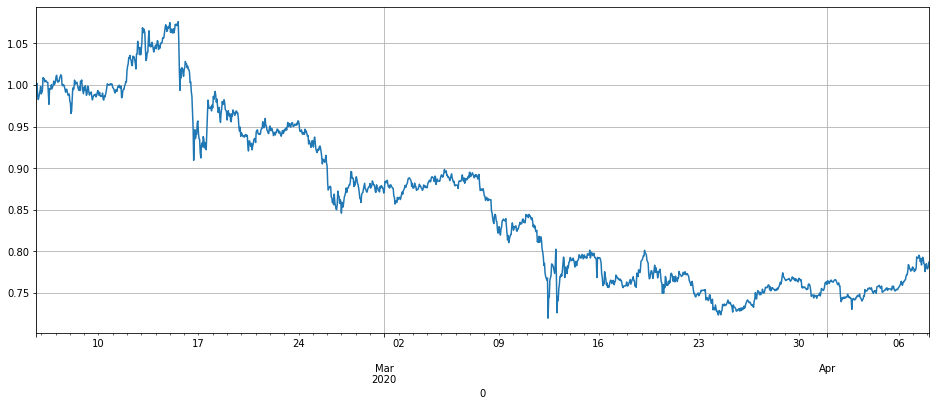

In [17]:
price_usdt_btc = price_usdt.divide(price_usdt['BTC'],axis=0)
price_usdt_btc_norm = price_usdt_btc/price_usdt_btc.fillna(method='bfill').iloc[0,]
price_usdt_btc_norm[trade_symbols].mean(axis=1).plot(figsize=(16,6),grid = True);
#price_usdt_btc_norm.mean(axis=1).plot(figsize=(16,6),grid = True,legend=False);

### 5.回测引擎

由于FMZ本地回测并没有所有币种的数据，也不支持多币种回测，所以需要重新实现一个回测引擎，写的比较简单，但也基本够用。考虑到了手续费，但基本忽略了资金费率，没有考虑维持保证金的情况。记录了总权益、占用保证金、杠杆等历史。由于这次策略基本多空对等的，所以资金费率的影响不大。

**回测并未考虑到滑价情况，可以自行加大手续费模拟，考虑到币安maker手续费低，即使是冷门币种的盘口差价也很小，实际下单中可以利用冰山委托的方式下单，影响应该不大。**

创建交易所对象时，需要指定要交易的币种，Buy做多，Sell做空，由于永续的限制，同时多空会自动平仓, 当做空时币种数量为负。参数如下：

- trade_symbols：要交易的币种列表
- leverage：杠杆，影响保证金,
- commission：手续费，默认万5  
- initial_balance：初始资产，USDT计价
- log：是否打印交易记录

In [18]:
class Exchange:
    
    def __init__(self, trade_symbols, leverage=20, commission=0.00005,  initial_balance=10000, log=False):
        self.initial_balance = initial_balance #初始的资产
        self.commission = commission
        self.leverage = leverage
        self.trade_symbols = trade_symbols
        self.date = ''
        self.log = log
        self.df = pd.DataFrame(columns=['margin','total','leverage','realised_profit','unrealised_profit'])
        self.account = {'USDT':{'realised_profit':0, 'margin':0, 'unrealised_profit':0, 'total':initial_balance, 'leverage':0}}
        for symbol in trade_symbols:
            self.account[symbol] = {'amount':0, 'hold_price':0, 'value':0, 'price':0, 'realised_profit':0, 'margin':0, 'unrealised_profit':0}
            
    def Trade(self, symbol, direction, price, amount, msg=''):
        if self.date and self.log:
            print('%-20s%-5s%-5s%-10.8s%-8.6s %s'%(str(self.date), symbol, 'buy' if direction == 1 else 'sell', price, amount, msg))
            
        cover_amount = 0 if direction*self.account[symbol]['amount'] >=0 else min(abs(self.account[symbol]['amount']), amount)
        open_amount = amount - cover_amount
        
        self.account['USDT']['realised_profit'] -= price*amount*self.commission #扣除手续费
        
        if cover_amount > 0: #先平仓
            self.account['USDT']['realised_profit'] += -direction*(price - self.account[symbol]['hold_price'])*cover_amount  #利润
            self.account['USDT']['margin'] -= cover_amount*self.account[symbol]['hold_price']/self.leverage #释放保证金
            
            self.account[symbol]['realised_profit'] += -direction*(price - self.account[symbol]['hold_price'])*cover_amount
            self.account[symbol]['amount'] -= -direction*cover_amount
            self.account[symbol]['margin'] -=  cover_amount*self.account[symbol]['hold_price']/self.leverage
            self.account[symbol]['hold_price'] = 0 if self.account[symbol]['amount'] == 0 else self.account[symbol]['hold_price']
            
        if open_amount > 0:
            total_cost = self.account[symbol]['hold_price']*direction*self.account[symbol]['amount'] + price*open_amount
            total_amount = direction*self.account[symbol]['amount']+open_amount
            
            self.account['USDT']['margin'] +=  open_amount*price/self.leverage            
            self.account[symbol]['hold_price'] = total_cost/total_amount
            self.account[symbol]['amount'] += direction*open_amount
            self.account[symbol]['margin'] +=  open_amount*price/self.leverage
            
        self.account[symbol]['unrealised_profit'] = (price - self.account[symbol]['hold_price'])*self.account[symbol]['amount']
        self.account[symbol]['price'] = price
        self.account[symbol]['value'] = abs(self.account[symbol]['amount'])*price
        
        return True
    
    def Buy(self, symbol, price, amount, msg=''):
        self.Trade(symbol, 1, price, amount, msg)
        
    def Sell(self, symbol, price, amount, msg=''):
        self.Trade(symbol, -1, price, amount, msg)
        
    def Update(self, date, close_price): #对资产进行更新
        self.date = date
        self.close = close_price
        self.account['USDT']['unrealised_profit'] = 0
        for symbol in self.trade_symbols:
            if np.isnan(close_price[symbol]):
                continue
            self.account[symbol]['unrealised_profit'] = (close_price[symbol] - self.account[symbol]['hold_price'])*self.account[symbol]['amount']
            self.account[symbol]['price'] = close_price[symbol]
            self.account[symbol]['value'] = abs(self.account[symbol]['amount'])*close_price[symbol]
            self.account['USDT']['unrealised_profit'] += self.account[symbol]['unrealised_profit']
            if self.date.hour in [0,8,16]:
                pass
                self.account['USDT']['realised_profit'] += -self.account[symbol]['amount']*close_price[symbol]*0.01/100
        
        self.account['USDT']['total'] = round(self.account['USDT']['realised_profit'] + self.initial_balance + self.account['USDT']['unrealised_profit'],6)
        self.account['USDT']['leverage'] = round(self.account['USDT']['margin']/self.account['USDT']['total'],4)*self.leverage
        self.df.loc[self.date] = [self.account['USDT']['margin'],self.account['USDT']['total'],self.account['USDT']['leverage'],self.account['USDT']['realised_profit'],self.account['USDT']['unrealised_profit']]

In [16]:
# 先测试一下回测引擎
e = Exchange(['BTC','XRP'],initial_balance=10000,commission=0,log=True)

e.Buy('BTC',100, 5)
e.Sell('XRP',10, 50)

e.Sell('BTC',105,e.account['BTC']['amount'])
e.Buy('XRP',9,-e.account['XRP']['amount'])

round(e.account['USDT']['realised_profit'],4)

75.0

### 6.第一个策略代码

策略逻辑：

- 1.检查币种价格，如果不为nan，则可以交易
- 2.检查山寨币合约价值，如果小于目标值trade_value，则卖空相应的差额，如果大于，则买入平仓相应的额度。
- 3.将所有山寨币空头价值相加，调整BTC仓位与之反向对冲。

做空的价值trade_value，决定了仓位的大小。设置log=True将打印交易日志


In [19]:
# 需要与BTC对冲
trade_symbols = list(set(symbols)-set(['LINK','XTZ','BCH', 'ETH', 'ETC','ATOM','BNB','EOS','LTC'])) #剩余的币种
e = Exchange(trade_symbols+['BTC'],initial_balance=10000,commission=0.0005,log=False)
trade_value = 2000
for row in price_usdt.iloc[:].iterrows():
    e.Update(row[0], row[1])
    empty_value = 0
    for symbol in trade_symbols:
        price = row[1][symbol]
        if np.isnan(price):
            continue
        if e.account[symbol]['value'] - trade_value  < -20 :
            e.Sell(symbol, price, round((trade_value-e.account[symbol]['value'])/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        if e.account[symbol]['value'] - trade_value > 20 :
            e.Buy(symbol, price, round((e.account[symbol]['value']-trade_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        empty_value += e.account[symbol]['value']
    price = row[1]['BTC']
    if e.account['BTC']['value'] - empty_value < -20:
        e.Buy('BTC', price, round((empty_value-e.account['BTC']['value'])/price,6),round(e.account['BTC']['realised_profit']+e.account['BTC']['unrealised_profit'],2))
    if e.account['BTC']['value'] - empty_value > 20:
        e.Sell('BTC', price, round((e.account['BTC']['value']-empty_value)/price,6),round(e.account['BTC']['realised_profit']+e.account['BTC']['unrealised_profit'],2))
stragey_1 = e

最终各个币种的利润如下：

In [20]:
pd.DataFrame(stragey_1.account).T.apply(lambda x:round(x,3))

,realised_profit,margin,unrealised_profit,total,leverage,amount,hold_price,value,price
USDT,5576.449,2350.526,-536.669,15057.009,3.176,NaN,NaN,NaN,NaN
DASH,847.374,86.354,-272.925,NaN,NaN,-26.788,64.472,2000.000,74.660
IOST,926.829,88.409,-231.819,NaN,NaN,-574052.813,0.003,2000.000,0.003
ONT,1302.690,85.751,-284.984,NaN,NaN,-4592.423,0.373,2000.000,0.436
XMR,654.856,77.073,-458.549,NaN,NaN,-34.471,44.717,2000.000,58.020
XLM,643.571,81.016,-379.678,NaN,NaN,-39737.731,0.041,2000.000,0.050
IOTA,1358.780,82.337,-353.258,NaN,NaN,-11764.706,0.140,2000.000,0.170
QTUM,902.930,87.172,-256.569,NaN,NaN,-1408.451,1.238,2000.000,1.420
BAT,1013.011,82.470,-350.592,NaN,NaN,-11750.881,0.140,2000.000,0.170
XRP,682.601,83.889,-322.224,NaN,NaN,-9985.022,0.168,2000.000,0.200


下面两幅图分别是净值曲线和使用的杠杆。

净值曲线中黄色的是1倍杠杆做空山寨币指数的效果，可以看到策略基本放大了指数的波动，符合预期。最终两个月收益60%，最大回撤20%，最大使用杠杆约8倍，大部分时间都在6倍以下，还是比较安全的。最重要的是，完全对冲使得策略在3月12号大跌中损失不大。

当做空的币价上涨，合约价值增加，此时是减仓的，反之盈利是加仓。这使得总的合约价值维持恒定，即使暴涨暴跌也损失有限。

但风险前面也提到了，山寨币是很有可能走出独立的行情的，并且有可能从底部抬升不少。这取决与如何使用，如果你看好山寨币并认为已经到底部，可以方向操作，做多指数。或者你看好某几个币种，可以和它们对冲。

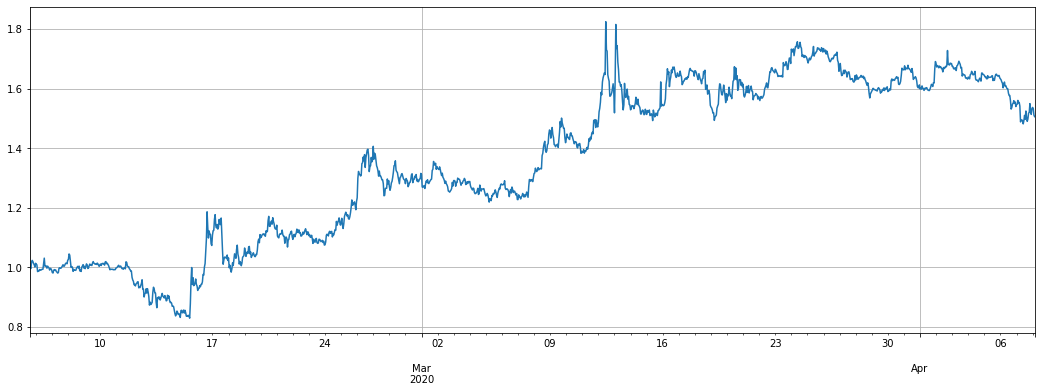

In [67]:
(stragey_1.df['total']/stragey_1.initial_balance).plot(figsize=(18,6),grid = True);#净值曲线
#(2-price_usdt_btc_norm[trade_symbols].mean(axis=1)).plot(figsize=(18,6),grid = True);

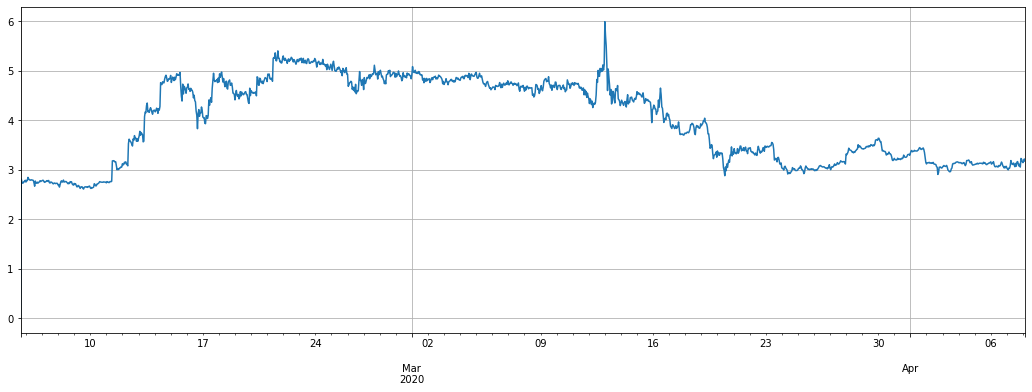

In [24]:
# 策略的杠杆
stragey_1.df['leverage'].plot(figsize=(18,6),grid = True);

**当然由于山寨币对USDT的价格也是下跌的，极端的方案是不对冲，直接裸空，但波动很大，回撤很高**

In [25]:
trade_symbols = list(set(symbols)-set(['LINK','XTZ','BCH', 'ETH', 'ETC','ATOM','BNB','EOS','LTC'])) #剩余的币种
e = Exchange(trade_symbols+['BTC'],initial_balance=10000,commission=0.0005,log=False)
trade_value = 2000
for row in price_usdt.iloc[:].iterrows():
    e.Update(row[0], row[1])
    empty_value = 0
    for symbol in trade_symbols:
        price = row[1][symbol]
        if np.isnan(price):
            continue
        if e.account[symbol]['value'] - trade_value  < -20 :
            e.Sell(symbol, price, round((trade_value-e.account[symbol]['value'])/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        if e.account[symbol]['value'] - trade_value > 20 :
            pass
            #e.Buy(symbol, price, round((e.account[symbol]['value']-trade_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        empty_value += e.account[symbol]['value']
stragey_1b = e

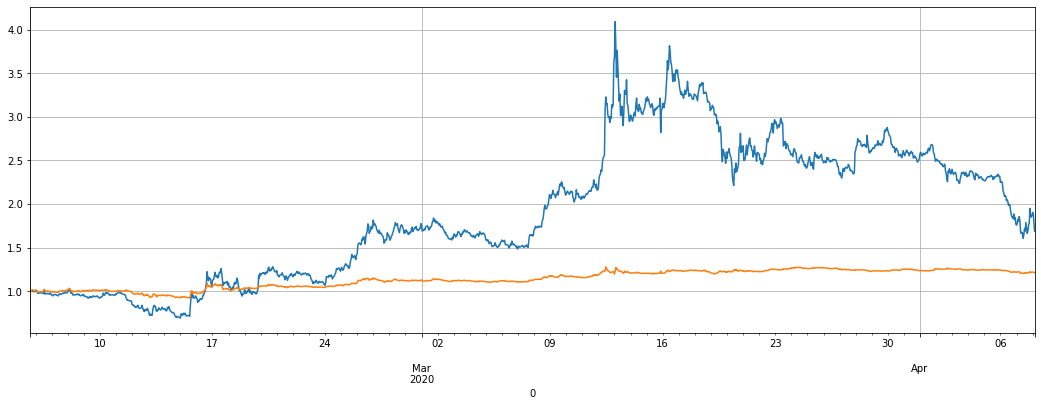

In [26]:
(stragey_1b.df['total']/stragey_1.initial_balance).plot(figsize=(18,6),grid = True);#净值曲线
(2-price_usdt_btc_norm[trade_symbols].mean(axis=1)).plot(figsize=(18,6),grid = True);

### 7.第二个策略代码

策略逻辑：

- 1.检查是否有价格，有价格进行交易
- 2.检查币种价格相对于指数的偏离
- 3.根据偏离判断做多做空,根据偏离大小判断仓位
- 4.计算未对冲的仓位用BTC对冲

同样由trade_value控制开仓大小。也可以修改diff/0.001的换算系数

In [31]:
trade_symbols = list(set(symbols)-set(['LINK','XTZ','BCH', 'ETH'])) #剩余的币种
price_usdt_btc_norm_mean = price_usdt_btc_norm[trade_symbols].mean(axis=1)
e = Exchange(trade_symbols+['BTC'],initial_balance=10000,commission=0.0005,log=False)
trade_value = 300
for row in price_usdt.iloc[:].iterrows():
    e.Update(row[0], row[1])
    empty_value = 0
    for symbol in trade_symbols:
        price = row[1][symbol]
        if np.isnan(price):
            continue
        diff = price_usdt_btc_norm.loc[row[0],symbol] - price_usdt_btc_norm_mean[row[0]]
        aim_value = -trade_value*round(diff/0.01,0)
        now_value = e.account[symbol]['value']*np.sign(e.account[symbol]['amount'])
        empty_value += now_value
        if aim_value - now_value > 50:
            e.Buy(symbol, price, round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        if aim_value - now_value < -50:
            e.Sell(symbol, price, -round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
    price = row[1]['BTC']
    aim_value = -empty_value
    now_value = e.account['BTC']['value']*np.sign(e.account['BTC']['amount'])
    if aim_value - now_value > 50:
        e.Buy('BTC', price, round((aim_value - now_value)/price, 6),round(e.account['BTC']['realised_profit']+e.account['BTC']['unrealised_profit'],2))
    if aim_value - now_value < -50:
        e.Sell('BTC', price, -round((aim_value - now_value)/price, 6),round(e.account['BTC']['realised_profit']+e.account['BTC']['unrealised_profit'],2))
stragey_2 = e

策略的收益相对第一个策略好上不少，近两个月有100%的收益，但还是有20%的回撤，并且最近一周由于行情波动较小，收益不明显。总体的杠杆也不多。这个策略值得尝试。根据偏离程度的不同，最多的开了7800多USDT。

注意到如果某个币走出了独立的行情，比如相对于指数上涨了几倍，将会在该币种上积累大量的做空仓位，同样的大幅下跌也会使得策略大量做多，可以限制最大开仓价值。

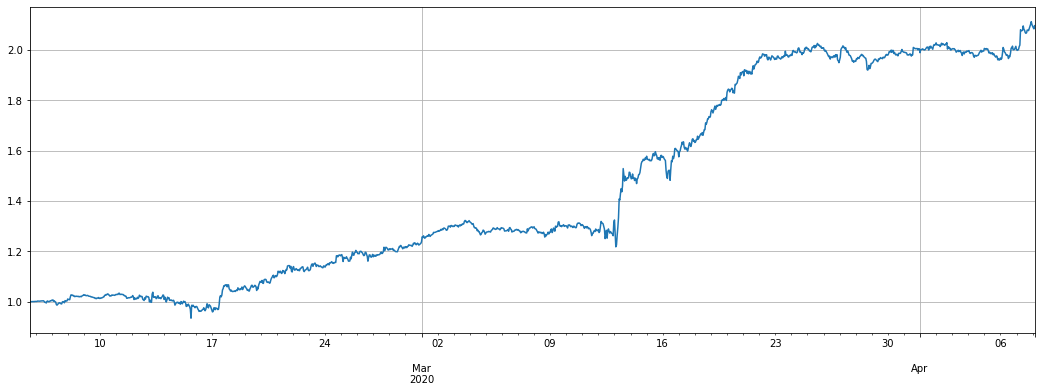

In [32]:
(stragey_2.df['total']/stragey_2.initial_balance).plot(figsize=(18,6),grid = True);

In [33]:
# 各币种汇总结果
pd.DataFrame(e.account).T.apply(lambda x:round(x,3))

,realised_profit,margin,unrealised_profit,total,leverage,amount,hold_price,value,price
USDT,11544.446,2240.648,-572.088,20961.347,2.142,NaN,NaN,NaN,NaN
LTC,208.435,71.269,-74.615,NaN,NaN,-32.134,44.358,1500.000,46.680
DASH,-1611.443,15.000,-0.000,NaN,NaN,-4.018,74.660,300.000,74.660
IOTA,-731.880,137.227,255.450,NaN,NaN,17647.059,0.156,3000.000,0.170
QTUM,3695.002,15.000,8.472,NaN,NaN,217.234,1.381,308.472,1.420
EOS,515.414,15.000,-16.148,NaN,NaN,-115.340,2.601,316.148,2.741
XRP,804.351,213.625,-527.496,NaN,NaN,-23964.054,0.178,4800.000,0.200
VET,2029.654,119.771,39.893,NaN,NaN,619674.671,0.004,2435.321,0.004
NEO,1046.044,44.474,39.211,NaN,NaN,116.595,7.629,928.682,7.965
ADA,606.302,29.077,-26.916,NaN,NaN,-16583.748,0.035,608.458,0.037


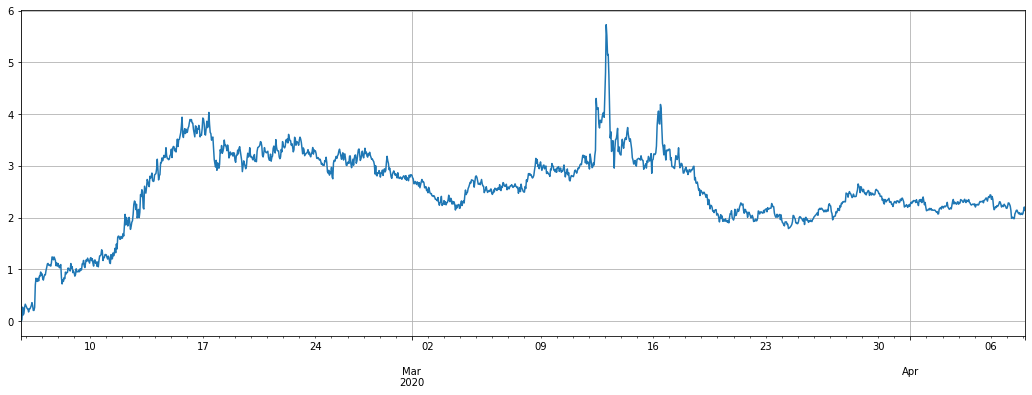

In [34]:
e.df['leverage'].plot(figsize=(18,6),grid = True);

如果不对冲的结果如下，实际上差别不大。因为多空基本是平衡的。

In [63]:
trade_symbols = list(set(symbols)-set(['LINK','XTZ','BCH', 'ETH']))#剩余的币种
price_usdt_btc_norm_mean = price_usdt_btc_norm[trade_symbols].mean(axis=1)
e = Exchange(trade_symbols,initial_balance=10000,commission=0.0005,log=False)
trade_value = 300
for row in price_usdt.iloc[:].iterrows():
    e.Update(row[0], row[1])
    empty_value = 0
    for symbol in trade_symbols:
        price = row[1][symbol]
        if np.isnan(price):
            continue
        diff = price_usdt_btc_norm.loc[row[0],symbol] - price_usdt_btc_norm_mean[row[0]]
        aim_value = -trade_value*round(diff/0.01,1)
        now_value = e.account[symbol]['value']*np.sign(e.account[symbol]['amount'])
        empty_value += now_value
        if aim_value - now_value > 20:
            e.Buy(symbol, price, round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        if aim_value - now_value < -20:
            e.Sell(symbol, price, -round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
stragey_2b = e

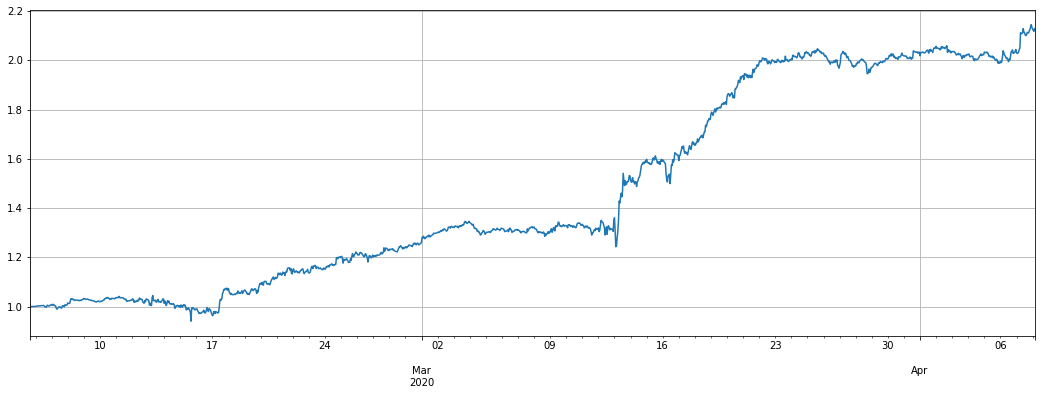

In [58]:
(stragey_2b.df['total']/stragey_2.initial_balance).plot(figsize=(18,6),grid = True);
#(stragey_2.df['total']/stragey_2.initial_balance).plot(figsize=(18,6),grid = True); #可叠加在一起看看

如果参考USDT的价格回归，效果会差很多

In [59]:
trade_symbols = list(set(symbols)-set(['LINK','XTZ','BCH', 'ETH']))+['BTC'] #剩余的币种
price_usdt_norm_mean = price_usdt_norm[trade_symbols].mean(axis=1)
e = Exchange(trade_symbols,initial_balance=10000,commission=0.0005,log=False)
trade_value = 300
for row in price_usdt.iloc[:].iterrows():
    e.Update(row[0], row[1])
    empty_value = 0
    for symbol in trade_symbols+['BTC']:
        price = row[1][symbol]
        if np.isnan(price):
            continue
        diff = price_usdt_norm.loc[row[0],symbol] - price_usdt_norm_mean[row[0]]
        aim_value = -trade_value*round(diff/0.01,1)
        now_value = e.account[symbol]['value']*np.sign(e.account[symbol]['amount'])
        empty_value += now_value
        if aim_value - now_value > 20:
            e.Buy(symbol, price, round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        if aim_value - now_value < -20:
            e.Sell(symbol, price, -round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
stragey_2c = e

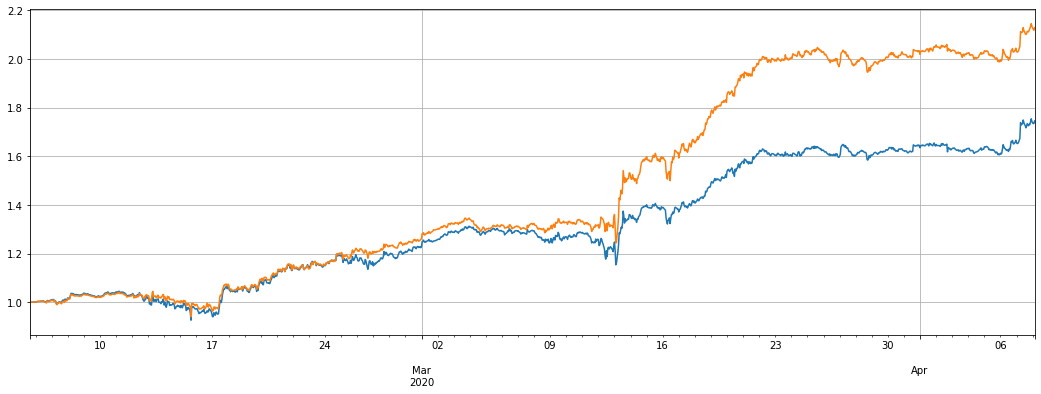

In [60]:
(stragey_2c.df['total']/stragey_2.initial_balance).plot(figsize=(18,6),grid = True);
(stragey_2b.df['total']/stragey_2.initial_balance).plot(figsize=(18,6),grid = True);

如果限制最大持仓价值,表现会差一些

In [64]:
trade_symbols = list(set(symbols)-set(['LINK','XTZ','BCH', 'ETH'])) #剩余的币种
price_usdt_btc_norm_mean = price_usdt_btc_norm[trade_symbols].mean(axis=1)
e = Exchange(trade_symbols+['BTC'],initial_balance=10000,commission=0.0005,log=False)
trade_value = 300
for row in price_usdt.iloc[:].iterrows():
    e.Update(row[0], row[1])
    empty_value = 0
    for symbol in trade_symbols:
        price = row[1][symbol]
        if np.isnan(price):
            continue
        diff = price_usdt_btc_norm.loc[row[0],symbol] - price_usdt_btc_norm_mean[row[0]]
        aim_value = -trade_value*round(diff/0.01,1)
        now_value = e.account[symbol]['value']*np.sign(e.account[symbol]['amount'])
        empty_value += now_value
        if aim_value - now_value > 20 and abs(aim_value)<3000:
            e.Buy(symbol, price, round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        if aim_value - now_value < -20 and abs(aim_value)<3000:
            e.Sell(symbol, price, -round((aim_value - now_value)/price, 6),round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
    price = row[1]['BTC']
    aim_value = -empty_value
    now_value = e.account['BTC']['value']*np.sign(e.account['BTC']['amount'])
    if aim_value - now_value > 20:
        e.Buy('BTC', price, round((aim_value - now_value)/price, 6),round(e.account['BTC']['realised_profit']+e.account['BTC']['unrealised_profit'],2))
    if aim_value - now_value < -20:
        e.Sell('BTC', price, -round((aim_value - now_value)/price, 6),round(e.account['BTC']['realised_profit']+e.account['BTC']['unrealised_profit'],2))
stragey_2d = e

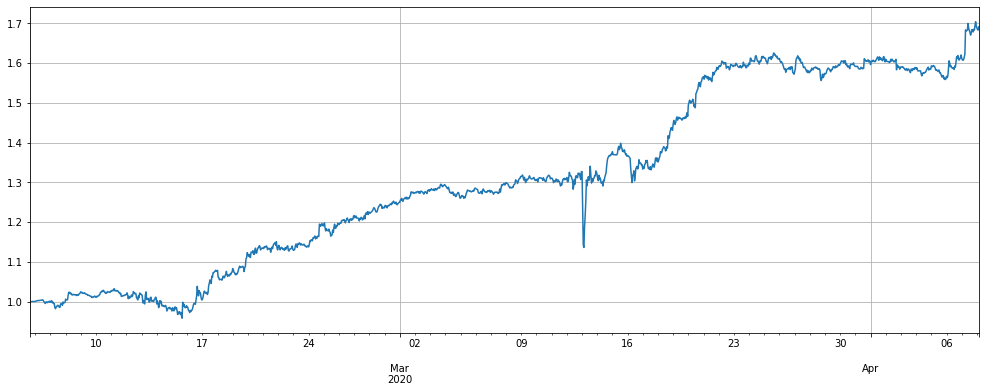

In [65]:
(stragey_2d.df['total']/stragey_2.initial_balance).plot(figsize=(17,6),grid = True);

### 8.总结与风险

第一个策略利用了山寨币总体价值不如比特币的特点，如果你看多比特币，不妨将这个策略长期坚持用下去，由于多空对等，也基本不怕8h一次的资金费率。长期来看，胜率比较高。但也担心山寨币目前在底部，有可能走出一段上涨的行情，造成策略的亏损。

第二个策略运用了山寨币的价格回归特性，涨的比指数多，大概率要跌回来。但可能会在单币种累计过多仓位，如果某个币真的一飞冲天不回头，会产生较大亏损。

由于策略的启动时间不同，具体参数不同，使用这个策略的人比较多时影响应该也不是很大。

**总之，没有完美的策略，只有正确看待策略的态度，它终究还取决与使用者对风险的理解和对未来的判断。**

这两个策略将在比赛前放出FMZ发明者量化平台的源码供大家参考。再此之前，也可以自己写出来，欢迎大家分享。